In [41]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn import preprocessing
from sklearn.model_selection import *
from models import *
from scipy.signal import lfilter


## **Exploratory Data Analysis**

In [210]:
data = pickle.load(open(r'../Data/deltaQ_cycles_v4.pkl', 'rb'))
#data2 = pickle.load(open(r'../Data/temp_features.pkl', 'rb'))

print(data['b1c1'].keys())

dict_keys(['cycle_life', 'DeltaQ_logVars', 'DeltaQ_mins', 'DeltaQ_means', 'DeltaT_max', 'DeltaT_logVars', 'DeltaIR', 'chargetime_policy'])


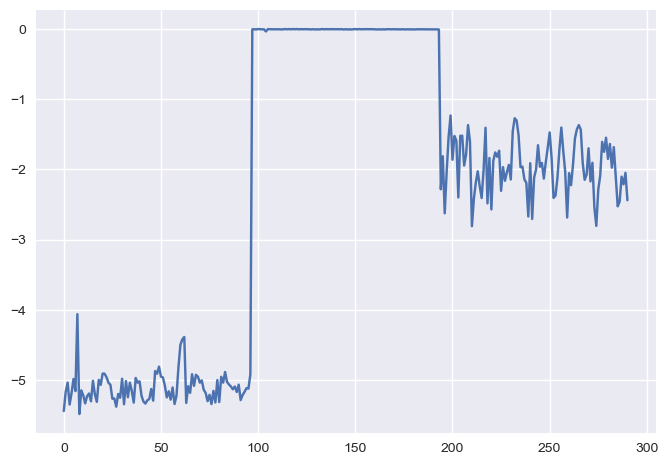

In [247]:
n_cycles = 98
cut_start = 1

features = [
    "DeltaQ_logVars",
    "DeltaQ_mins",
    #"DeltaQ_means",
    # "DeltaT_max",
    "DeltaT_logVars",
]

n_cycles = n_cycles - cut_start
y = np.zeros(124)
charge_policies = np.zeros(124)
x = np.zeros((124, n_cycles*len(features)))

for i, cell in enumerate(data.keys()):
    for j, feature in enumerate(features):
        x[i, j*n_cycles:(j+1)*n_cycles] = data[cell][feature][cut_start:]
    charge_policies[i] = 1/(data[cell]["chargetime_policy"])
    y[i] = np.log10(data[cell]["cycle_life"])

# convert to tensors and concatenate features and labels
x = torch.Tensor(x)
y = torch.Tensor(y)


plt.plot(x[1])

## **AutoEncoder: Dimensionality Reduction**

### **Train Test Split**

In [248]:
test_ind = np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

train_ind = np.array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

secondary_ind = np.array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123])


Stage 1:

Epoch 60/600,   	decoding loss: 1.35,    	prediction loss: 22050.44,  	reg_loss: 1.72
Epoch 120/600,   	decoding loss: 1.11,    	prediction loss: 4910.55,  	reg_loss: 1.59
Epoch 180/600,   	decoding loss: 1.00,    	prediction loss: 54753.39,  	reg_loss: 1.49
Epoch 240/600,   	decoding loss: 1.14,    	prediction loss: 134404.22,  	reg_loss: 1.43
Epoch 300/600,   	decoding loss: 1.16,    	prediction loss: 7413.50,  	reg_loss: 1.42
Epoch 360/600,   	decoding loss: 0.92,    	prediction loss: 4045.33,  	reg_loss: 1.41
Epoch 420/600,   	decoding loss: 1.10,    	prediction loss: 898.10,  	reg_loss: 1.40
Epoch 480/600,   	decoding loss: 1.36,    	prediction loss: 464262.81,  	reg_loss: 1.38
Epoch 540/600,   	decoding loss: 0.94,    	prediction loss: 9285.71,  	reg_loss: 1.37
Epoch 600/600,   	decoding loss: 1.15,    	prediction loss: 18257.37,  	reg_loss: 1.36

train 	 117.73395
test 	 140.5793
sec 	 337.59384


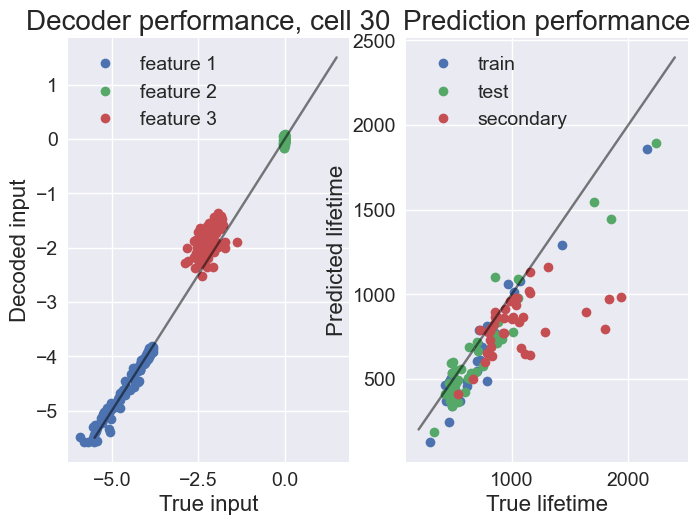

In [250]:
train_policy = {
    "num_stages": 1,
    "epochs": [600],
    "learning_rates": [1e-4],
    "batch_sizes": [8],
    "prediction_weights": [4],
    "decoding_weights": [3],
    "en_weights": [1]
}


model = AutoEncoder_ElasticNet(n_features=len(features), n_cycles=n_cycles)
#train = TensorDataset(torch.Tensor(x[train_ind]),torch.Tensor(y[train_ind]))
model.fit(x,y, train_policy)

In [251]:
model.encoder(x[5])

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.4829, 0.0000, 0.0000, 2.2963,
        0.0000, 0.0000, 0.0000, 2.6011, 0.0000, 1.4538, 0.0000, 0.0000, 1.2725,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.9955, 0.0000, 0.0000,
        0.4781, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7431,
        0.0000, 2.8283, 2.9004, 1.6831, 0.0000, 0.0000, 0.0000, 1.4159, 0.0000,
        0.2185, 4.5004, 3.6590], grad_fn=<ReluBackward0>)

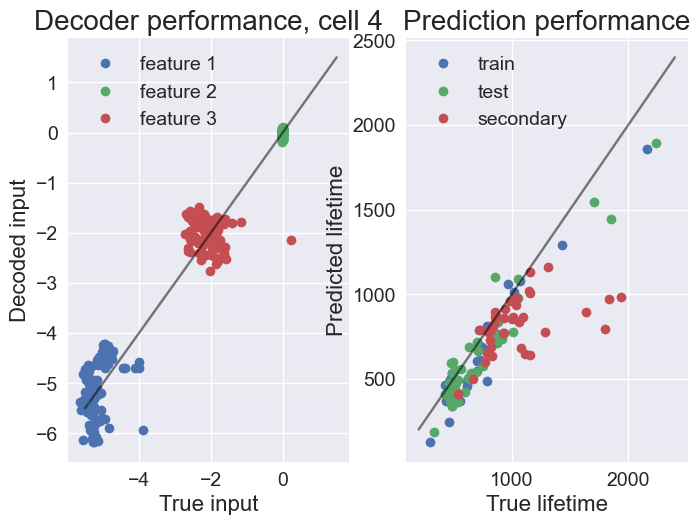

In [252]:
model.plotter(x, y, 4)

In [253]:
print(y[1], model.elastic_net_predict(x[1]))

tensor(3.3345) tensor([3.2688], grad_fn=<AddBackward0>)


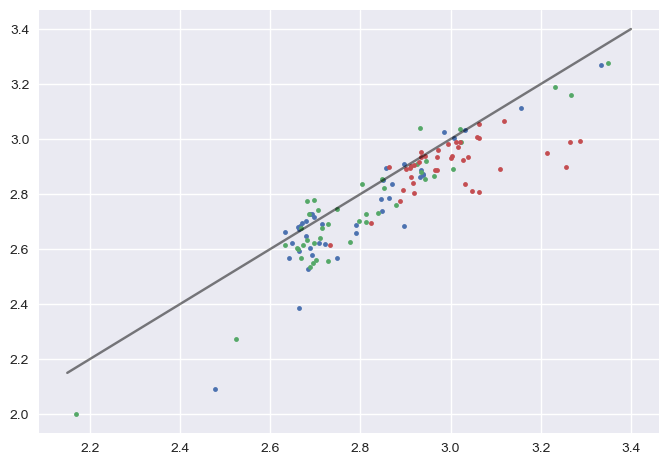

In [254]:
plt.plot(y[train_ind], model.elastic_net_predict(x[train_ind]).detach().numpy(), ".")
plt.plot(y[test_ind], model.elastic_net_predict(x[test_ind]).detach().numpy(), ".")
plt.plot(y[secondary_ind], model.elastic_net_predict(x[secondary_ind]).detach().numpy(), ".")
plt.plot(np.linspace(2.15, 3.4, 3), np.linspace(2.15, 3.4, 3), "k", alpha = 0.5)

In [255]:
print(np.array([charge_policies[train_ind]]).T)

[[3.6       ]
 [4.        ]
 [4.4       ]
 [4.8       ]
 [3.85714286]
 [4.09090909]
 [4.5       ]
 [4.35483871]
 [5.4       ]
 [3.75      ]
 [4.28571429]
 [4.        ]
 [4.5       ]
 [4.28571429]
 [4.21404682]
 [3.88888889]
 [4.46808511]
 [3.92370572]
 [4.17391304]
 [4.45820433]
 [5.        ]
 [4.85436893]
 [4.92782479]
 [5.        ]
 [4.84261501]
 [5.        ]
 [4.8415493 ]
 [5.        ]
 [4.81068686]
 [4.99865628]
 [4.8       ]
 [4.78958741]
 [4.67819836]
 [4.73588342]
 [4.61811723]
 [4.28807037]
 [4.67859249]
 [4.47284345]
 [4.29667519]
 [4.67246908]
 [4.78991597]]


# SVR

In [256]:
x_t = np.hstack((model.encoder(x[train_ind]).detach().numpy(), np.array([charge_policies[train_ind]]).T))
x_te = np.hstack((model.encoder(x[test_ind]).detach().numpy(), np.array([charge_policies[test_ind]]).T))
x_ste = np.hstack((model.encoder(x[secondary_ind]).detach().numpy(), np.array([charge_policies[secondary_ind]]).T))

print(x_t)

[[0.         0.         0.         ... 5.03049564 3.99137783 3.6       ]
 [0.         0.         0.         ... 4.78452444 3.85920954 4.        ]
 [0.         0.         0.         ... 4.50040531 3.65900421 4.4       ]
 ...
 [0.         0.         0.         ... 4.22896147 3.54516768 4.29667519]
 [0.         0.         0.         ... 4.03346395 3.40326595 4.67246908]
 [0.         0.         0.         ... 4.20678759 3.47416973 4.78991597]]


In [257]:
# scaler = preprocessing.StandardScaler().fit(list(x_t))
# x_t = scaler.transform(list(x_t))
# x_te = scaler.transform(list(x_te))
# x_ste = scaler.transform(list(x_ste))

train = TensorDataset(torch.Tensor(x_t),torch.Tensor(y[train_ind]))
test = TensorDataset(torch.Tensor(x_te),torch.Tensor(y[test_ind]))
stest = TensorDataset(torch.Tensor(x_ste),torch.Tensor(y[secondary_ind]))

In [264]:
# parameters
lr = 0.0001
feat_dim = 3*16+1
d_model = 12
nepoch = 2000
batch_size = 1

In [265]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [266]:
# Load nodel, loss function, and optimizer
model = AttentionModel(feat_dim=feat_dim,d_model=d_model, skip_connect=2)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


model.train()

# Training loop
for i in range(nepoch):
    total_loss_train = 0.0
    total_loss_test = 0.0
    total_loss_stest = 0.0

    train_batched = DataLoader(train,batch_size=batch_size,shuffle=True)
    test_batched = DataLoader(test,batch_size=1)
    stest_batched = DataLoader(stest,batch_size=1)

    for j,batch in enumerate(train_batched):
        optimizer.zero_grad()
        train_input, train_label = batch
        output = model(train_input.to(device))
        loss = criterion(10**output, 10**train_label)
        total_loss_train += loss.item()

        loss.backward()
        optimizer.step()

    for cell in test_batched:
        test_input, test_label = cell
        test_output = model(test_input.to(device))
        test_loss = criterion(10**test_output, 10**test_label)

        total_loss_test += test_loss.item()

    for cell in stest_batched:
        stest_input, stest_label = cell
        stest_output = model(stest_input.to(device))
        stest_loss = criterion(10**stest_output, 10**stest_label)
        

        # print(i, output, train_label, loss)
        total_loss_stest += stest_loss.item()

    rmse_train = np.sqrt(total_loss_train / (j+1))
    rmse_test = np.sqrt(total_loss_test / len(test))
    rmse_stest = np.sqrt(total_loss_stest / len(stest))
    #wandb.log({"Epoch": i+1, "RMSE_train": rmse_train, "RMSE_test": rmse_test, "RMSE_stest": rmse_stest})
    if (i+1)%50 == 0: 
        print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f} | rmse_test: {rmse_test: .3f} | rmse_stest: {rmse_stest: .3f}')

#wandb.finish()

Epochs: 50 | rmse:  225.795 | rmse_test:  212.451 | rmse_stest:  339.439
Epochs: 100 | rmse:  197.732 | rmse_test:  185.348 | rmse_stest:  327.497
Epochs: 150 | rmse:  163.792 | rmse_test:  159.319 | rmse_stest:  316.132
Epochs: 200 | rmse:  133.578 | rmse_test:  134.811 | rmse_stest:  305.989
Epochs: 250 | rmse:  114.066 | rmse_test:  119.394 | rmse_stest:  294.883
Epochs: 300 | rmse:  102.591 | rmse_test:  113.798 | rmse_stest:  289.552
Epochs: 350 | rmse:  100.616 | rmse_test:  110.635 | rmse_stest:  283.722
Epochs: 400 | rmse:  101.110 | rmse_test:  110.142 | rmse_stest:  283.030
Epochs: 450 | rmse:  104.108 | rmse_test:  109.160 | rmse_stest:  279.203
Epochs: 500 | rmse:  91.129 | rmse_test:  109.899 | rmse_stest:  283.150
Epochs: 550 | rmse:  92.288 | rmse_test:  111.693 | rmse_stest:  285.453
Epochs: 600 | rmse:  95.498 | rmse_test:  109.158 | rmse_stest:  281.776
Epochs: 650 | rmse:  89.190 | rmse_test:  109.006 | rmse_stest:  280.382
Epochs: 700 | rmse:  86.207 | rmse_test:  1

In [244]:
plt.style.use("seaborn-v0_8")
from matplotlib.patches import Patch

85.69569354229782
97.45145595657279
261.3138205461499


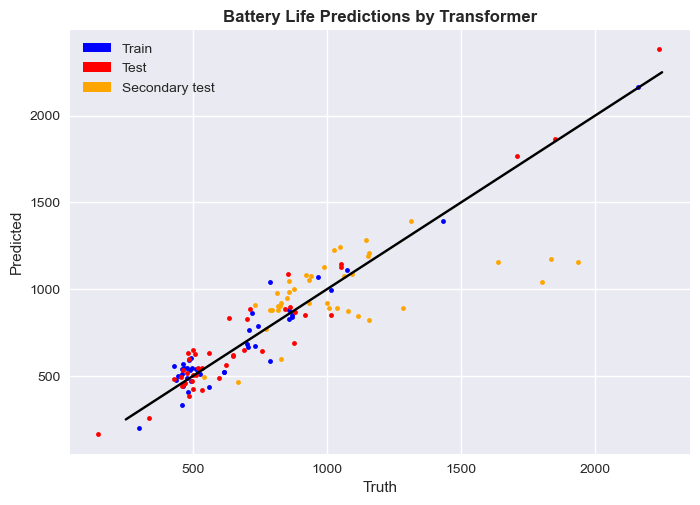

In [245]:
fig,ax = plt.subplots()
colors = ["blue","red","orange"]
for i,dataset in enumerate([train,test,stest]):
    predicted =[]
    labels = []
    for cell in dataset:
        input, label = cell
        predicted.append(10**model(input[None,:].to(device)).detach().numpy()[0,0])
        labels.append(10**label)
    print(np.sqrt(np.mean(np.power(np.array(predicted)-np.array(labels),2))))

    ax.plot(labels, predicted, ".",color=colors[i])
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")

ax.plot(np.linspace(250,2250),np.linspace(250,2250),color="black")
ax.set_title("Battery Life Predictions by Transformer",fontweight="semibold")

legend_elements = [Patch(facecolor='blue', label='Train'),
                   Patch(facecolor='red', label='Test'),
                   Patch(facecolor='orange', label='Secondary test')]
ax.legend(handles=legend_elements)
#plt.savefig("../images/transformer_output.png",dpi=300)

(array([ 3.,  0.,  4.,  9.,  8., 14.,  0.,  0.,  0.,  2.]),
 array([0.20073294, 0.20373236, 0.20673178, 0.20973121, 0.21273063,
        0.21573005, 0.21872948, 0.2217289 , 0.22472833, 0.22772775,
        0.23072717]),
 <BarContainer object of 10 artists>)

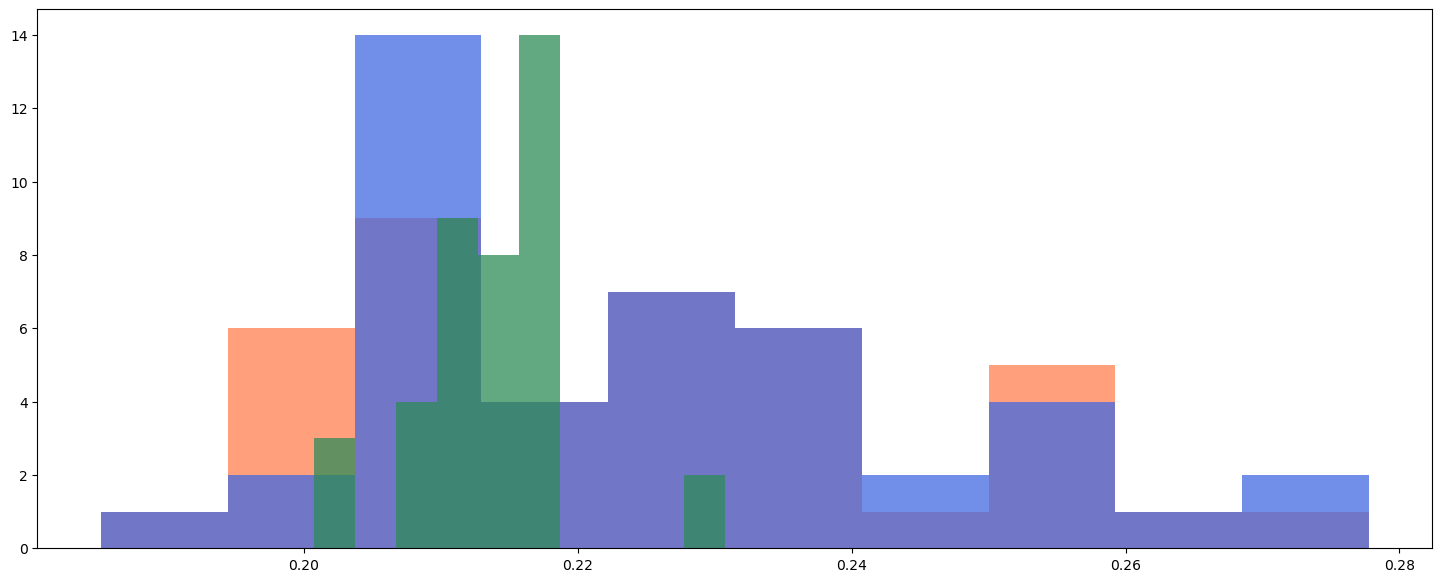

In [227]:
fig,ax=plt.subplots()
ax.hist(charge_policies[train_ind], color='coral',alpha=0.75)
plt.hist(charge_policies[test_ind], color='royalblue',alpha=0.75)
ax.hist(charge_policies[secondary_ind], color='seagreen',alpha=0.75)